In [ ]:
from functions_wind import load_data, calculate_energy_output, calculate_daily_output, save_results, plot_wind_results, set_date_as_index
import constants as c
import constants_wind as cw
import os
import tkinter as tk


def wind_sim():
    location_data = {'latitude': c.BREITENGRAD, 'longitude': c.LAENGENGRAD}
    filename = f"pv_gis_data_{location_data['latitude']}_{location_data['longitude']}.csv"
    file_path = os.path.join(c.DATA_FOLDER, filename)

    # CSV-Datei einlesen
    df_wind = load_data(file_path)

    # Datumsspalte als Index setzen
    df_wind = set_date_as_index(df_wind)

    # Ertragsberechnung durchführen
    df_wind = calculate_energy_output(df_wind, cw.CUT_IN_SPEED, cw.RATED_SPEED, cw.CUT_OUT_SPEED, cw.RATED_POWER)

    # Gesamtertrag berechnen
    total_energy_output = df_wind['power_output'].sum()

    # Ergebnis speichern
    save_results(df_wind, c.EXPORT_FOLDER, f"wind_power_output_{location_data['latitude']}_{location_data['longitude']}")

    # # Täglicher Ertrag berechnen
    # daily_energy_output = calculate_daily_output(df)


    # Plotten der Ergebnisse
    plot_wind_results(df_wind, cw.CUT_IN_SPEED, cw.RATED_SPEED, cw.CUT_OUT_SPEED, total_energy_output)

    print(f"Gesamtertrag: {total_energy_output} Wh")

if __name__ == "__main__":
    wind_sim()

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import constants as c 
import constants_wind as cw 
from functions import create_data_folder

# Parameter
cut_in_speed = cw.CUT_IN_SPEED  # m/s, Windgeschwindigkeit, ab der Strom produziert wird
rated_speed = cw.RATED_SPEED  # m/s, Windgeschwindigkeit, bei der die Nennleistung erreicht wird
cut_out_speed = cw.CUT_OUT_SPEED  # m/s, Windgeschwindigkeit, ab der die Anlage abschaltet
rated_power = cw.RATED_POWER  # W, Nennleistung der Anlage

# Funktion zur Berechnung der Leistungskurve
def power_curve(wind_speed, cut_in_speed, rated_speed, cut_out_speed, rated_power):
    if wind_speed < cut_in_speed:
        return 0
    elif cut_in_speed <= wind_speed < rated_speed:
        # Quadratische Annäherung von Schnittgeschwindigkeit zu Nenngeschwindigkeit
        return rated_power * ((wind_speed - cut_in_speed) / (rated_speed - cut_in_speed)) ** 3
    elif rated_speed <= wind_speed < cut_out_speed:
        return rated_power
    else:
        return 0

# Dateipfad und Datei laden
location_data = {'latitude': c.BREITENGRAD, 'longitude': c.LAENGENGRAD}
filename = f"pv_gis_data_{location_data['latitude']}_{location_data['longitude']}.csv"
file_path = os.path.join(c.DATA_FOLDER, filename)

# CSV-Datei einlesen
df_wind = pd.read_csv(file_path, parse_dates=[0])

# Ertragsberechnung durchführen
df_wind['power_output'] = df_wind['wind_speed'].apply(lambda ws: power_curve(ws, cut_in_speed, rated_speed, cut_out_speed, rated_power))

# Gesamtertrag berechnen (z.B. Gesamtleistung in einem bestimmten Zeitraum)
total_energy_output = df_wind['power_output'].sum()

# Ergebnis speichern
create_data_folder(c.EXPORT_FOLDER)
output_filename = f"wind_power_output_{location_data['latitude']}_{location_data['longitude']}.csv"
output_path = os.path.join(c.EXPORT_FOLDER, output_filename)
df_wind.to_csv(output_path, index=False)
output_filename = f"wind_power_output_{location_data['latitude']}_{location_data['longitude']}.xlsx"
output_path = os.path.join(c.EXPORT_FOLDER, output_filename)
df_wind.to_excel(output_path, index=False)

# Aggregation der Daten nach Tag und Berechnung des täglichen Ertrags
df_wind['date'] = df_wind.iloc[:, 0].dt.date
daily_energy_output = df_wind.groupby('date')['power_output'].sum()

# Plotten der Leistungskurve und des täglichen Ertrags
fig, axs = plt.subplots(2, 1, figsize=(10, 12))

# Leistungskurve
axs[0].plot(df_wind['wind_speed'], df_wind['power_output'], label='Leistungskurve', linestyle='none', marker='o')
axs[0].axvline(cut_in_speed, color='grey', linestyle='--', label='Schnittgeschwindigkeit')
axs[0].axvline(rated_speed, color='red', linestyle='--', label='Nenngeschwindigkeit')
axs[0].axvline(cut_out_speed, color='grey', linestyle='--', label='Abschaltgeschwindigkeit')
axs[0].set_xlabel('Windgeschwindigkeit (m/s)')
axs[0].set_ylabel('Leistung (W)')
axs[0].set_title('Leistungskurve einer Kleinwindkraftanlage basierend auf CSV-Daten')
axs[0].legend()
axs[0].grid(True)

# Täglicher Ertrag
axs[1].plot(daily_energy_output.index, daily_energy_output.values, label='Täglicher Ertrag')
axs[1].set_xlabel('Datum')
axs[1].set_ylabel('Täglicher Ertrag (Wh)')
axs[1].set_title('Täglicher Energieertrag über das Jahr')
axs[1].legend()
axs[1].grid(True)

plt.tight_layout()
plt.show()

print(f"Gesamtertrag: {total_energy_output} Wh")


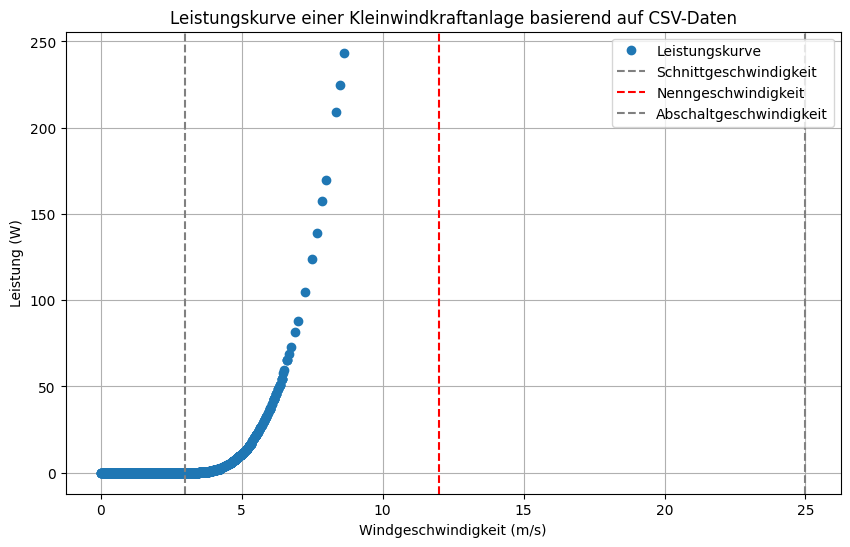

Gesamtertrag: 6134.202079561043 Wh


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import constants as c

# Parameter
cut_in_speed = 3  # m/s, Windgeschwindigkeit, ab der Strom produziert wird
rated_speed = 12  # m/s, Windgeschwindigkeit, bei der die Nennleistung erreicht wird
cut_out_speed = 25  # m/s, Windgeschwindigkeit, ab der die Anlage abschaltet
rated_power = 1000  # W, Nennleistung der Anlage

# Funktion zur Berechnung der Leistungskurve
def power_curve(wind_speed, cut_in_speed, rated_speed, cut_out_speed, rated_power):
    if wind_speed < cut_in_speed:
        return 0
    elif cut_in_speed <= wind_speed < rated_speed:
        # Quadratische Annäherung von Schnittgeschwindigkeit zu Nenngeschwindigkeit
        return rated_power * ((wind_speed - cut_in_speed) / (rated_speed - cut_in_speed)) ** 3
    elif rated_speed <= wind_speed < cut_out_speed:
        return rated_power
    else:
        return 0

# Dateipfad und Datei laden
location_data = {'latitude': c.BREITENGRAD, 'longitude': c.LAENGENGRAD}
filename = f"pv_gis_data_{location_data['latitude']}_{location_data['longitude']}.csv"
DATA_FOLDER = 'pv_data'
file_path = os.path.join(DATA_FOLDER, filename)

# CSV-Datei einlesen
df_wind = pd.read_csv(file_path)

# Ertragsberechnung durchführen
df_wind['power_output'] = df_wind['wind_speed'].apply(lambda ws: power_curve(ws, cut_in_speed, rated_speed, cut_out_speed, rated_power))

# Gesamtertrag berechnen (z.B. Gesamtleistung in einem bestimmten Zeitraum)
total_energy_output = df_wind['power_output'].sum()

# Ergebnis speichern
output_filename = f"wind_power_output_{location_data['latitude']}_{location_data['longitude']}.csv"
output_path = os.path.join(DATA_FOLDER, output_filename)
df_wind.to_csv(output_path, index=False)

# Plotten der Leistungskurve
plt.figure(figsize=(10, 6))
plt.plot(df_wind['wind_speed'], df_wind['power_output'], label='Leistungskurve', linestyle='none', marker='o')
plt.axvline(cut_in_speed, color='grey', linestyle='--', label='Schnittgeschwindigkeit')
plt.axvline(rated_speed, color='red', linestyle='--', label='Nenngeschwindigkeit')
plt.axvline(cut_out_speed, color='grey', linestyle='--', label='Abschaltgeschwindigkeit')
plt.xlabel('Windgeschwindigkeit (m/s)')
plt.ylabel('Leistung (W)')
plt.title('Leistungskurve einer Kleinwindkraftanlage basierend auf CSV-Daten')
plt.legend()
plt.grid(True)
plt.show()

print(f"Gesamtertrag: {total_energy_output} Wh")
